# Introduction

This notebook implements some applications of the NLP course at DSSC AA 2021-2022. 

In particular, I will perform topic modeling using LDA and sentiment analysis for a dataset of book reviews from amazon. The data set was found at:

https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

# Downloading the dataset

The dataset can be downloaded in the link above.

The dataset contains of two main files: 
- Books_rating.csv: contains all the information for 3 million book reviews for approximately 200,000 books. Namely, the book id, the book title, the user id who rated the book, the review/score, the summary of the review, and the full text of the former. 
- books_data.csv: contains all the information for the 200,000 books, namely, the title, the author name, the summary, the category of the book, etc. 

In [2]:
# import statements for the whole notebook
import pandas as pd

import spacy
import nltk
#nltk.download('all')

import re
import pickle

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#load spacys english dictionary. 
nlp = spacy.load("en_core_web_sm")


c:\Users\andre\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Global variable to stop execution in notebook re runs
FIRST_RUN = False

In [5]:
df_books = pd.read_csv("./DataSet/books_data.csv")
df_books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


# Topic Modeling

We briefly recall the idea behind topic modeling. We want to extract the main topics that the books are talking about in their descriptions. To this end, we use Latent Dirichlet Allocation. 

As a brief recap, LDA is a document generating model which assumes that all documents are generated by sampling a specific topic distribution and sampling the words most relevant to each topic in a proportional manner.

Of course, this assumption is faulty in some ways since it doesn't account for dependence between consecutive words. However, it works.

We can reverse engineer the process to find the $k$ topics being discussed and, for each topic, the top words which describe it. This is done to give us an idea of what the topic is about. 


## Step 0: Extract Data and Explore

We begin by extracting the columns we are interested in, namely the description. However, since also the titles of the books are useful in terms of information, we will join the two columns together and separate them with a period. 

Furthermore, we must also check that all the descriptions are in english since we have no information regarding this fact. To do this, we use **spacy_fastlang** library to detect the language.

In [7]:
df_books = df_books.dropna(subset = ["description"])
df_books["new_desc"] = df_books.loc[:,"description"] + ". " + df_books.loc[:,"Title"]
newdate = [re.sub(r"[^0-9].*","",date ) for date in df_books["publishedDate"].apply(str)]
df_books["publishedDate"] = newdate
df_books = df_books.drop(["image", "publisher", "infoLink", "ratingsCount", "previewLink"], axis = 1)

In [ ]:
#for language detection, uncomment

#!pip install spacy_fastlang
#import spacy_fastlang

#nlp.add_pipe("language_detector")


In [151]:
if FIRST_RUN:
    #check if the summaries are in english. Runtime is approximately 1 hr
    lang = [nlp(doc)._.language for doc in df_books["new_desc"]]
    df_books["lang"] = lang
    df_books_en = df_books[df_books["lang"] == "en"]
    with open("./DataSet/books_en.csv", "wb") as fp:
            pickle.dump(df_books_en, fp)
else:
    with open("./DataSet/books_en.csv", "rb") as fp:
            df_books_en = pickle.load(fp)
book_description_corpus = df_books_en["new_desc"].tolist()

len(book_description_corpus)

142149

As we can see, the final corpus contains approximatley 150,000 documents in english. Below we show an example:

In [9]:
book_description_corpus[0]


'Philip Nel takes a fascinating look into the key aspects of Seuss\'s career - his poetry, politics, art, marketing, and place in the popular imagination." "Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like "nerd." And Seuss\'s famously loopy artistic style - what Nel terms an "energetic cartoon surrealism" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover. Dr. Seuss: American Icon'

In [46]:
cat_num = 10
fig = px.bar(df_books_en["categories"].value_counts()[:cat_num][::-1], orientation = "h", title = f"Top {cat_num} Categories")
fig.show()

## Step 1: Preprocessing

Before using LDA, we must do some aggressive preprocessing in order to reduce the most variance. Notably, the proprocessing for LDA has to be much more aggressive than other tasks since we want to capture important words in order to define our topics clearly. 

For example, if we don't lemmatize or stem, we could find that the top descriptors of a topic are simply all the conjugations of a word. This is not very informative and thus must be avoided at all costs. 

The preprocessing steps that we will emply are as follows:
- tokenization
- normalization
- lemmatization
- stopword removal

In [11]:
def normalize(text):
    '''This function removes punctuation, symbols, and numbers. Returns the text into lower case.
      Input: a string of text
      Output: cleaned a string of text
    '''
    no_punctuation = re.sub(r'[^\w^\s^-^\']','',text)
    no_numbers = re.sub(r'[0-9+]', '0', no_punctuation)
    downcase = no_numbers.lower()
    return downcase

def clean_corpus(corpus):
    '''This function preprocesses each document of the corpus by first normalizing it and then keeping only the lemma of the word
     if the word is not a stop word.
     Input: a list of strings (documents)
     Outout: a list of strings (documents) which have been preprocessed.
    '''
    clean_corpus = [] 
    for document in corpus:
        lowered_text = normalize(document)
        clean_corpus.append(' '.join([token.lemma_ for token in nlp(lowered_text) if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'] and not token.is_stop]))
    return clean_corpus 

In [12]:
print(book_description_corpus[0])
print(clean_corpus(book_description_corpus[0:1]))


Philip Nel takes a fascinating look into the key aspects of Seuss's career - his poetry, politics, art, marketing, and place in the popular imagination." "Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like "nerd." And Seuss's famously loopy artistic style - what Nel terms an "energetic cartoon surrealism" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover. Dr. Seuss: American Icon
['philip nel take fascinating look key aspect seuss career poetry politic art marketing place popular imagination nel argue convincingly dr seuss influential poet america nonsense verse lewis carroll edward lear change language give new word nerd seuss famously loopy artistic style nel term energetic cartoon surrealism equally important inspiring artist filmmaker tim burton illustrator lan

In [13]:
# collocations

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm

def collocation_finder(cleaned_corpus, min_freq = 10, thresh = 1):
    words = [word for document in cleaned_corpus for word in document.split()]   
    finder = BigramCollocationFinder.from_words(words)
    bgm = BigramAssocMeasures()
    score = bgm.mi_like
    finder.apply_freq_filter(min_freq)
    collocations = pd.DataFrame(finder.score_ngrams(score), columns = ["bigram", "pmi"])
    return collocations[collocations["pmi"] >= thresh]
def replace_words_with_collocations(cleaned_corpus, collocations):
    corpus_with_collocations = []
    for document in tqdm(cleaned_corpus):
        for word1, word2 in collocations:
            document = re.sub(f'{word1} {word2}', f'{word1}_{word2}', document)
        corpus_with_collocations.append(document)
    return corpus_with_collocations


We can now finally preprocess the corpus by first applying the pipeline and then finding all collocations and adding them to the documents as bigrams. 

In [14]:
#preprocess corpus and save once

if FIRST_RUN:
    book_description_corpus_cleaned = clean_corpus(book_description_corpus)

    with open("./DataSet/book_description_cleaned.csv", "wb") as fp:
        pickle.dump(book_description_corpus_cleaned, fp)
else:
    with open("./DataSet/book_description_cleaned.csv", "rb") as fp:
        book_description_corpus_cleaned = pickle.load(fp)


In [15]:
collocations = collocation_finder(book_description_corpus_cleaned)

In [16]:
collocations

,bigram,pmi
0,"(united, states)",3860.036858
1,"(york, times)",1570.857642
2,"(new, york)",1257.851052
3,"(los, angeles)",742.395737
4,"(san, francisco)",388.615226
...,...,...
1300,"(professionally, typeset)",1.007619
1301,"(p, lovecraft)",1.001788
1302,"(british, columbia)",1.001537
1303,"(fort, sumter)",1.000000


In [17]:
if FIRST_RUN:
    book_description_corpus_cleaned_collocations = replace_words_with_collocations(book_description_corpus_cleaned, collocations["bigram"])
    
    with open("./DataSet/books_description_corpus_cleaned_with_collocations.csv", "wb") as fp:
        pickle.dump(book_description_corpus_cleaned_collocations, fp)
else:
    with open("./DataSet/books_description_corpus_cleaned_with_collocations.csv", "rb") as fp:
        book_description_corpus_cleaned_collocations = pickle.load(fp)

In [18]:
i = 29
print(book_description_corpus[i], "\n")
print(book_description_corpus_cleaned[i], "\n")
print(book_description_corpus_cleaned_collocations[i], "\n")

The United States "Explorer" map is a classic example of the cartographic excellence National Geographic is known for. This colorful political map clearly shows state boundaries, capitals, major highways, rivers, lakes, and many major cities. Insets show detail of Alaska and Hawaii. The color palette is vibrant and stunning shaded relief provides additional texture and detail. The map is encapsulated in heavy-duty 1.6 mil laminate which makes the paper much more durable and resistant to the swelling and shrinking caused by changes in humidity. Laminated maps can be framed without the need for glass, so the fames can be much lighter and less expensive. "Map Scale = 1:6,396,000Sheet Size = 32" x 20.25"". Usa Laminated Map 

united states explorer map classic example cartographic excellence national geographic know colorful political map clearly show state boundary capital major highway river lake major city inset detail alaska hawaii color palette vibrant stunning shaded relief provide a

### Word Cloud


In [ ]:
import stylecloud


words = " ".join(book_description_corpus_cleaned_collocations)
wordcloud = stylecloud.gen_stylecloud(
                        text = words,
                        size = 1028,
                        background_color = "black",
                        output_name = "./Images/wordcloud.png",
                        icon_name = "fas fa-book"
                        )



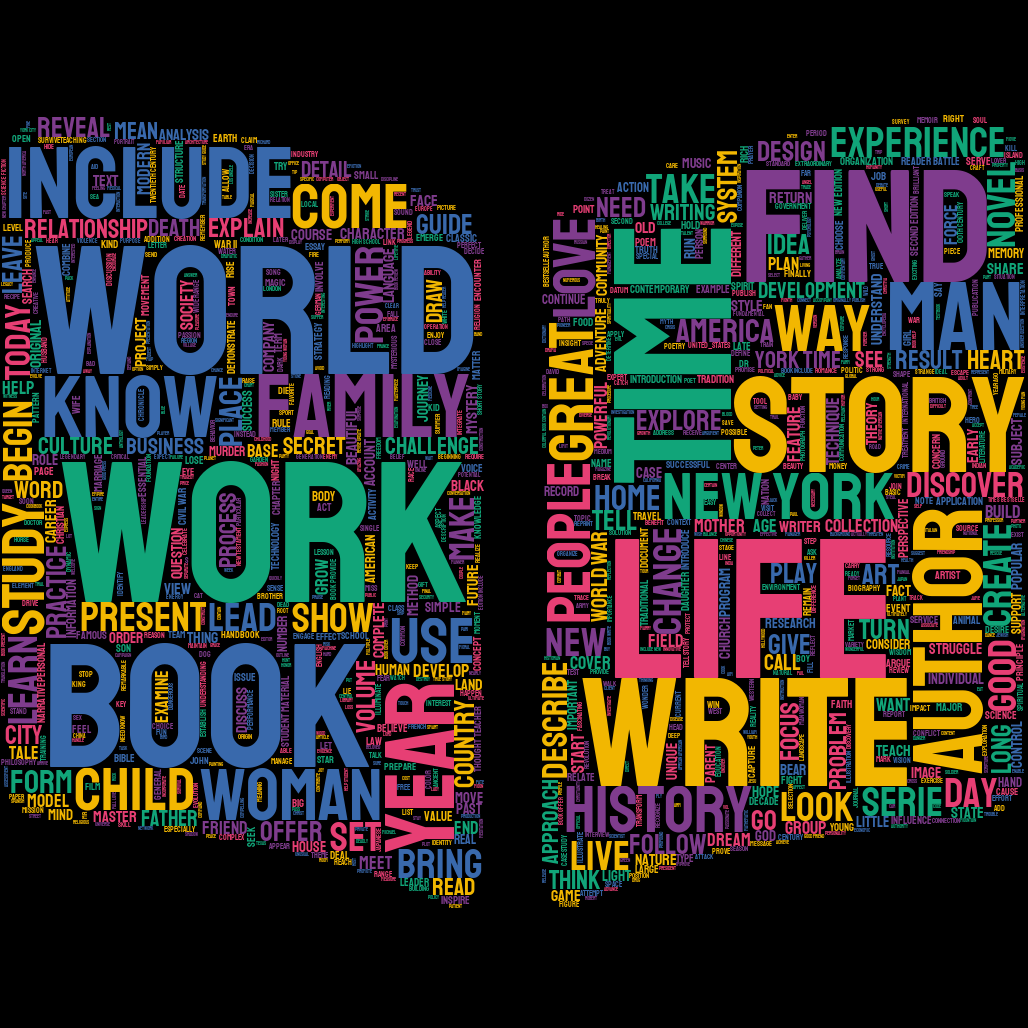

## Using Gensim

To apply LDA, we use the gensim library which is the most popular library for this task

In [21]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time 
import multiprocessing 

In [24]:
instances = [doc.split() for doc in book_description_corpus_cleaned_collocations]
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below = 50, no_above = 0.5)

ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

In [25]:
i = 1 
print(book_description_corpus_cleaned_collocations[i])
print(instances[i])
print(ldacorpus[i])
print(model_corpus[i])

resource include principle understand small church worship practice planning worship few people suggestion congregational study wonderful worship small church
['resource', 'include', 'principle', 'understand', 'small', 'church', 'worship', 'practice', 'planning', 'worship', 'few', 'people', 'suggestion', 'congregational', 'study', 'wonderful', 'worship', 'small', 'church']
[(51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3)]
[(51, 0.31376452057035326), (52, 0.32180463855405556), (53, 0.2693150375467911), (54, 0.0664025240567632), (55, 0.09767008421079369), (56, 0.19392337346329966), (57, 0.12066432336191125), (58, 0.1504597029346263), (59, 0.1314502090225251), (60, 0.28331521221527595), (61, 0.09744878989309225), (62, 0.1936860437731818), (63, 0.11980735412718313), (64, 0.18348738900751174), (65, 0.666431806837864)]


### Choosing number of topics
To choose the number of topics we use measures such as 

In [30]:
coherence_values = []

dev_size = 100000
eval_size = 30000

for num_topics in range(2, 21):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         random_state = 2)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    print(f"Number of topics: {num_topics}, UMass Score: {umass_score}, CV Score: {cv_score} \n")
    coherence_values.append((num_topics, umass_score, cv_score))

Number of topics: 2, UMass Score: -1.9605988643372265, CV Score: 0.3161597160060067 

Number of topics: 3, UMass Score: -1.9717528690166812, CV Score: 0.29431340607395245 

Number of topics: 4, UMass Score: -2.005779097776581, CV Score: 0.3064429016914327 

Number of topics: 5, UMass Score: -2.0269277266492507, CV Score: 0.31563442611381015 

Number of topics: 6, UMass Score: -2.053769982167863, CV Score: 0.315766214867727 

Number of topics: 7, UMass Score: -2.010900744638036, CV Score: 0.3169885581834011 

Number of topics: 8, UMass Score: -2.0597289045429577, CV Score: 0.3154455716383609 

Number of topics: 9, UMass Score: -2.036263730354967, CV Score: 0.30268530259809956 

Number of topics: 10, UMass Score: -2.0345074490719113, CV Score: 0.3180204074656512 

Number of topics: 11, UMass Score: -2.089334649556665, CV Score: 0.29665755564040147 

Number of topics: 12, UMass Score: -2.026210672008201, CV Score: 0.3269589351828821 

Number of topics: 13, UMass Score: -2.0360165325245614

In [40]:
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("UMass Score", "CV Score"))

fig.add_trace(
    go.Scatter(x=scores["num_topics"], y=scores["UMass"]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=scores["num_topics"], y=scores["CV"]),
    row=1, col=2
)

fig.update_xaxes(title_text="Num. Topics", row=1, col=1)
fig.update_xaxes(title_text="Num. Topics", row=1, col=2)

fig.update_yaxes(title_text="Coherence Score", row=1, col=1)


fig.update_layout(height=600, width=800, title_text="Choosing Number of Topics Via UMass and CV scores")
fig.show()

As we can see, the optimal number of topics is 7 since it is the peak of the UMass and CV scores.

## Results

Having chosen the number of topics, we can analyze what they represent

In [42]:
if FIRST_RUN: 
    num_topics = 7
    
    # find chunksize to make about 200 updates
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200
    print(f"chunk size: {chunk_size}")
    
    start = time.time()
    print("fitting model", flush=True)
    model = LdaMulticore(num_topics=num_topics, # number of topics
                         corpus=model_corpus, # what to train on 
                         id2word=dictionary, # mapping from IDs to words
                         workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                         passes=num_passes, # make this many passes over data
                         chunksize=chunk_size, # update after this many instances
                         alpha=0.5,
                         random_state = 2
                        )
        
    print("done in {}".format(time.time()-start), flush=True)
    with open("./Models/model_lda", "wb") as fp:
        pickle.dump(model, fp)
else:
    with open("./Models/model_lda", "rb") as fp:
        model = pickle.load(fp)


chunk size: 7107.45
fitting model
done in 352.34129548072815


In [43]:
def get_descriptors(model, num_words = 5):
    topic_sep = re.compile(r"0\.[0-9]{3}\*|\+|\"") # getting rid of useless formatting
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic)) for topic_no, model_topic in
                    model.print_topics(num_words=num_words)]
    descriptors = {}
    for i, m in model_topics:
        descriptors[f"topic {i+1}"] = m.split()
    return pd.DataFrame.from_dict(descriptors, orient = "index", columns = [f"Word {i}" for i in range(1,num_words+1)])

In [50]:
topics = get_descriptors(model, 10)
topics

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
topic 1,theory,study,social,history,science,culture,work,book,introduction,modern
topic 2,art,guide,design,include,edition,book,feature,dictionary,color,work
topic 3,guide,student,business,help,provide,child,practice,information,learn,system
topic 4,god,bible,life,book,spiritual,christian,jesus,work,church,christ
topic 5,love,man,story,woman,life,novel,family,find,young,murder
topic 6,war,history,world,military,american,political,new,life,book,civil
topic 7,story,adventure,animal,christmas,book,song,music,little,great,tale


As we can see, the topics are quite easy to interpret:
- topic 1: words such as "theory", "study", "history", "science" indicate that this topic belongs to **academia**
- topic 2: words such as "guide" along with "design" and "art" indicate that this topic belongs to **art**.
- topic 3: words such as "guide" along with "student", "business", "help" and "provide" tell us that this topic deals with **student help**.
- topic 4: words such as "god", "bible" indicate a religious theme: **religion**.
- topic 5: words such as "love", "man", "woman", "murder" indicate the theme of **fiction & romance**.
- topic 6: words such as "war", "history", "military", "american" suggest a theme of **american war history**.
- topic 7: words such as "story", "adventure", "animal", "book" indicate a theme related to **children books**.


As we can see, these themes more or less relate to the top 10 categories with a few important observations:
- The theme **art** is not present in the top 10 categories. 
- Looking at the top 10 categories we could think that the theme of **fiction & romance** could  actually related to the category of **biography & autobiography** since the descriptors could very well be dealing with someone's personal life. 
- The theme of **student help** is probably associated to the theme of **juvenile non-fiction**

Finally, lets analyze how the popularity of these themes changed throughout the years.

In [91]:
topic_corpus = model[model_corpus]
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(book_description_corpus))]


In [152]:
df_books_en[["topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7"]]=scores

In [153]:
df_books_en

,Title,description,authors,publishedDate,categories,new_desc,lang,topic1,topic2,topic3,topic4,topic5,topic6,topic7
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],2005,['Biography & Autobiography'],Philip Nel takes a fascinating look into the k...,en,0.095130,0.340764,0.068506,0.075415,0.064876,0.266570,0.088739
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],2000,['Religion'],This resource includes twelve principles in un...,en,0.105597,0.084881,0.199642,0.347270,0.083063,0.088499,0.091049
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],2005,['Fiction'],Julia Thomas finds her life spinning out of co...,en,0.056008,0.054771,0.063038,0.090354,0.606541,0.068405,0.060883
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],1996,['Religion'],In The Church of Christ: A Biblical Ecclesiolo...,en,0.085947,0.068766,0.075421,0.549577,0.081188,0.074279,0.064822
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],2009,['Biography & Autobiography'],The story for children 10 and up of St. Hyacin...,en,0.082401,0.073128,0.071681,0.275148,0.091007,0.322728,0.083908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],2000,['Juvenile Fiction'],"During a school trip to Ellis Island, Dominick...",en,0.082278,0.091112,0.083885,0.081321,0.338309,0.086601,0.236494
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,1995,['Juvenile Fiction'],Everyone in the village of Friedensdorf is hap...,en,0.082209,0.089091,0.087297,0.098683,0.233809,0.092970,0.315941
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],2018,NaN,"Give your Mamaw a useful, beautiful and though...",en,0.071210,0.113667,0.081025,0.233818,0.134653,0.081190,0.284437
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],2003,['Fiction'],Alex-Li Tandem sells autographs. His business ...,en,0.113216,0.085311,0.081603,0.099031,0.417966,0.082309,0.120565


In [154]:
df_books_en.loc[98662,"publishedDate"] = "2007" #Wrong Data point
years = df_books_en["publishedDate"].value_counts().sort_index(ascending=False)[:14]
years.pop("2023")
years

2022    1006
2021    2645
2020    2724
2019    2697
2018    2766
2017    2992
2016    3187
2015    3540
2014    4288
2013    5098
2012    5218
2011    4532
2010    3906
Name: publishedDate, dtype: int64

In [155]:
print(sum(years.values))
years = years.index.tolist()

44599


In [156]:
import numpy as np
df_books_en["publishedDate"].replace("",np.nan, inplace=True)
df_books_en = df_books_en.dropna(subset = ["publishedDate"])
df_years = df_books_en[(df_books_en["publishedDate"].apply(int) > 2009) & (df_books_en["publishedDate"].apply(int) < 2023)]
df_years

,Title,description,authors,publishedDate,categories,new_desc,lang,topic1,topic2,topic3,topic4,topic5,topic6,topic7
12,Mensa Number Puzzles (Mensa Word Games for Kids),Acclaimed teacher and puzzler Evelyn B. Christ...,['Evelyn B. Christensen'],2018,['Juvenile Nonfiction'],Acclaimed teacher and puzzler Evelyn B. Christ...,en,0.081379,0.206227,0.368441,0.074345,0.093401,0.071278,0.104929
13,Vector Quantization and Signal Compression (Th...,"Herb Caen, a popular columnist for the San Fra...","['Allen Gersho', 'Robert M. Gray']",2012,['Technology & Engineering'],"Herb Caen, a popular columnist for the San Fra...",en,0.281639,0.166511,0.293628,0.065531,0.059910,0.065226,0.067555
14,A husband for Kutani,"First published in 1938, this is a collection ...",['Frank Owen'],2018,['History'],"First published in 1938, this is a collection ...",en,0.079303,0.154894,0.067302,0.214772,0.250086,0.110496,0.123148
16,The Ultimate Guide to Law School Admission: In...,This collection brings together a distinguishe...,['Fiona Cownie'],2010,['Law'],This collection brings together a distinguishe...,en,0.140504,0.069417,0.428557,0.091853,0.068621,0.115173,0.085873
17,The Repeal of Reticence: A History of America'...,At a time when America's faculties of taste an...,['Rochelle Gurstein'],2016,['Political Science'],At a time when America's faculties of taste an...,en,0.169678,0.070360,0.144317,0.102388,0.102878,0.352481,0.057897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212348,Watercolor: For the Artistically Undiscovered ...,Put the brush in your hand. Stick it in the wa...,"['Thacher Hurd', 'John Cassidy']",2017,['Art'],Put the brush in your hand. Stick it in the wa...,en,0.060808,0.403781,0.083427,0.081929,0.241133,0.060765,0.068156
212375,Sell and Re-Sell Your Photos,Sell your photos again and again! Live anywher...,"['Rohn Engh', 'Mikael Karlsson']",2016,['Photography'],Sell your photos again and again! Live anywher...,en,0.056735,0.290012,0.332104,0.077475,0.060911,0.120815,0.061948
212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],2015,['Fiction'],Grace's father believes in science and builds ...,en,0.058780,0.056405,0.055993,0.077312,0.604928,0.058690,0.087891
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,"['Daniel Banach', 'Travis Jones']",2016,['Computers'],Autodesk Inventor 2017 Essentials Plus provide...,en,0.057221,0.286917,0.451048,0.053184,0.047131,0.053911,0.050588


In [158]:
df_years = df_years.groupby(df_years.publishedDate).mean()

fig = go.Figure(data=[
    go.Bar(name="academia", x=df_years.index, y=df_years["topic1"]),
    go.Bar(name="art", x=df_years.index, y=df_years["topic2"]),
    go.Bar(name="student help", x=df_years.index, y=df_years["topic3"]),
    go.Bar(name="religion", x=df_years.index, y=df_years["topic4"]),
    go.Bar(name="fiction & romance", x=df_years.index, y=df_years["topic5"]),
    go.Bar(name="american war history", x=df_years.index, y=df_years["topic6"]),
    go.Bar(name="children books", x=df_years.index, y=df_years["topic7"]),

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

Some notable observations from the bar chart above:
- In the last three years the popularity of books related to **fiction & romance** have gone up. This could be due to the difficult times due to the pandemic which undoubtedly left lots of people with desires of affection and human contact. 
link: https://www.frontiersin.org/articles/10.3389/fpsyg.2021.798260/full
- There was a noticeable increase in popularity of books related to **academia** in during 2012-2013. This could be linked to the boom in popularity of massive open online courses - MOOCs in those years. Since academic books are one of the most essential supplements to an education, it could be that the boom in MOOCs cause an increase in the production of academic texts.  
link: https://onlinelearninginsights.wordpress.com/2012/12/21/what-the-heck-happened-in-2012-review-of-the-top-three-events-in-education/


# Sentiment Analysis
In this section we will analyze the reviews from various users and perform sentiment analysis. This is a useful application in NLP since it can be used to know the sentiment towards a specific book based on the reviews. This information can be used by publishing companies and authors alike to know which products are liked most and what the public likes/dislikes.

In particular we will use the reviews dataset which we saw earlier.

In [3]:
df_reviews = pd.read_csv("./DataSet/Books_rating.csv" )

In [4]:
print(f"The Data Set contains {len(df_reviews)/1e6} million reviews")
df_reviews = df_reviews.rename(columns = {"review/helpfulness":"helpfulness", "review/score":"score", "review/time":"time", "review/summary":"summary", "review/text":"text"})

df_reviews.head()


The Data Set contains 3.0 million reviews


,Id,Title,Price,User_id,profileName,helpfulness,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


### Analysis of Data Set
 
We analyze the distribution of the scores and find the most frequent words for the positive and negative reviews.

In [1]:
fig = px.bar(df_reviews["score"].apply(int), orientation = "h", title = f"Distribution of scores")
fig.show()

NameError: name 'px' is not defined

As we can see, 

In [2]:
from transformers import AutoTokenizer,  AutoModelForSequenceClassification, pipeline
import torch 

model_name = "siebert/sentiment-roberta-large-english"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

classifier("I hate this!")

[{'label': 'NEGATIVE', 'score': 0.9994561076164246}]